# Covid-19 Cases Predictions using LSTM Recurrent model

Importing the required python packages

In [311]:
import pandas as pd
import requests
import io
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds



Converting the data in CSV format to Data Frame

In [312]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'  , sep = ',')

cols = df.T.iloc[4: , :  ].diff().fillna(0).T
df = pd.concat([df.iloc[: , 0:4] , cols]  , axis = 1 ) 
df.drop('Province/State' , axis = 1 , inplace = True)
cols = df.columns

dd  = pd.DataFrame(columns= cols)

def fun(frame):
    
    mean_lat = frame['Lat'].mean() 
    meanlong = frame['Long'].mean() 
    country = frame['Country/Region'].values[0]
    # print(frame)
    a = frame.agg('sum')
    a.Lat = mean_lat 
    a.Long = meanlong 
    a['Country/Region'] = country
    vals = a.values
    dd.loc[len(dd.index)] = list(vals)  

df.groupby(['Country/Region']).apply(lambda frame  : fun(frame) )

cases_trend = dd.iloc[: , 3 : ].agg('sum')
cases_trend.rolling(100).mean().dropna(inplace = True)
cases_day_wise = cases_trend.values
standardDeviation = cases_day_wise.std()
variance = np.sqrt(standardDeviation)
average = cases_day_wise.mean()
MAD = cases_trend.mad()
AAD = cases_trend.mad()
print(average, variance, standardDeviation, MAD , AAD) 


615732.5190839694 780.9389223013303 609865.6003651633 374207.11342579103 374207.11342579103


C:\Users\Student\AppData\Local\Temp\ipykernel_10700\326440591.py:31: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  MAD = cases_trend.mad()
C:\Users\Student\AppData\Local\Temp\ipykernel_10700\326440591.py:32: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  AAD = cases_trend.mad()


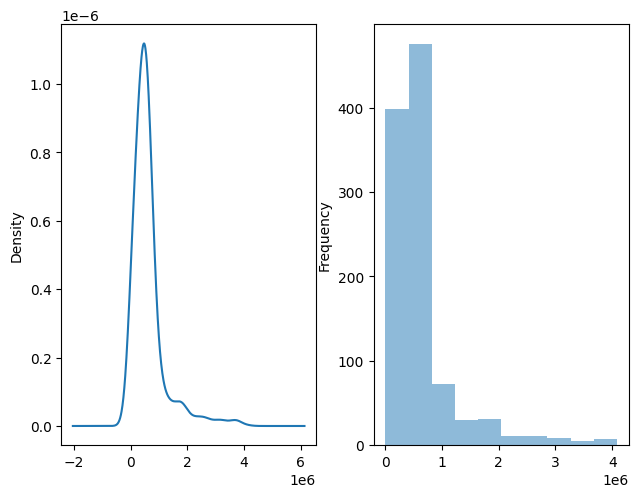

In [313]:
# It only gives how many data points may be present around specified values.
fig, (ax1 , ax2) = plt.subplots(1 ,2 , sharey=False ,sharex= False)
fig.tight_layout()
ax1 = cases_trend.plot.kde(bw_method = 0.3 , ax = ax1)
ax2 = cases_trend.plot.hist(alpha=0.5 , ax = ax2)
plt.show()


(-52.35, 1099.35, -204217.05000000002, 4288558.05)

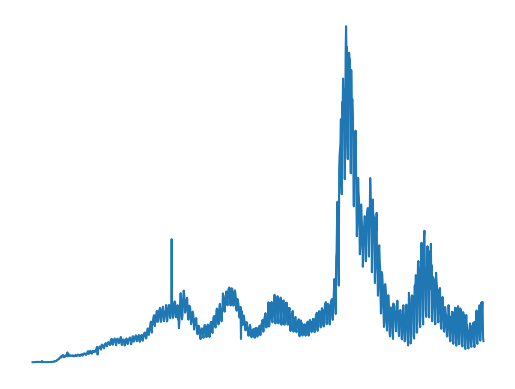

In [314]:
ax = plt.plot(cases_trend)
plt.axis('off')

In [315]:
split_size = 0.85
split_ndx = int(dd.shape[0]*split_size )

dd = dd.drop(['Lat' , 'Long'] , axis = 1 ).set_index('Country/Region')
train_df = dd.iloc[ : split_ndx , : ]
test_df =  dd.iloc[split_ndx : , :  ]  
cols = dd.columns

d = {} 

for i in cols : 
    d[i] = tf.int16
    

Creating data in TensorFlow Format

In [316]:
my_ds_train = tf.data.Dataset.from_tensor_slices(dict(train_df))
my_ds_test = tf.data.Dataset.from_tensor_slices(dict(test_df))

# Optionally define a custom `data_dir`.
# If None, then the default data dir is used.



# Define the builder.

covid_cases_builder = tfds.dataset_builders.TfDataBuilder(
    name="Covid cases",
    config="CovidData",
    version="1.0.0",
    split_datasets={
        "train": my_ds_train,
        "test": my_ds_test,
    },
    features=tfds.features.FeaturesDict(d),
    description="Dataset with covid cases",
    release_notes={
        "1.0.0": "Initial release with cases till 22 November , 2022",
    }
)

# Make the builder store the data as a TFDS dataset.
covid_cases_builder.download_and_prepare()

In [317]:
df = dd.copy()

In [318]:
df22 = df.T[4:]

In [319]:
df22['Sum'] = df22.sum(axis=1)

In [320]:
df22.head(2)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe,Sum
1/26/20,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,683
1/27/20,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,809


In [321]:
dates = df.index

In [322]:
dates_prediction = dates[-194:]

# Splitting of Datasets


In [323]:
df = df22
close_data = df['Sum'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

# date_train = df['Date'][:split]
# date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

835
209


In [324]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [325]:
model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 125
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

C:\Users\Student\AppData\Local\Temp\ipykernel_10700\3894425179.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=num_epochs, verbose=1)


Epoch 1/125
41/41 [==============================] - 5s 7ms/step - loss: 825998704640.0000
Epoch 2/125
41/41 [==============================] - 0s 7ms/step - loss: 814877245440.0000
Epoch 3/125
41/41 [==============================] - 0s 8ms/step - loss: 803687497728.0000
Epoch 4/125
41/41 [==============================] - 0s 8ms/step - loss: 789899640832.0000
Epoch 5/125
41/41 [==============================] - 0s 8ms/step - loss: 773476712448.0000
Epoch 6/125
41/41 [==============================] - 0s 9ms/step - loss: 756745961472.0000
Epoch 7/125
41/41 [==============================] - 0s 11ms/step - loss: 733396008960.0000
Epoch 8/125
41/41 [==============================] - 0s 10ms/step - loss: 709457215488.0000
Epoch 9/125
41/41 [==============================] - 0s 10ms/step - loss: 684220022784.0000
Epoch 10/125
41/41 [==============================] - 0s 11ms/step - loss: 651361058816.0000
Epoch 11/125
41/41 [==============================] - 0s 10ms/step - loss: 6159538585

In [326]:
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))
#prediction

C:\Users\Student\AppData\Local\Temp\ipykernel_10700\1585461578.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(test_generator)


# Accuracy for LSTM model

In [327]:
# correct = df['Sum'].values
correct = close_test.reshape((-1,1))
correct = correct[-194:]
#len(correct)

In [328]:
#len(prediction)

In [329]:
mse = ((correct - prediction)**2).mean()

# Prediction of cases along with the dates

In [330]:
#dates_prediction

In [331]:
type(dates_prediction) 
cases_dates = pd.DataFrame(dates_prediction)

In [332]:
cases_dates['Cases'] = prediction


# Country wise predictions


In [333]:
#df22

In [334]:
df22 = df22.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
#df22

In [335]:
df_new = df22[['Sum']].copy()

In [336]:
def partition_dataset(sequence_length, data, index):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Model training - LSTM

In [337]:
def getNext(feature, model):
    df22 = df_new
    data = df22
    data_filtered = df22
    data_filtered_ext = data_filtered.copy()
    data_filtered_ext['Prediction'] = data_filtered_ext[feature]

    nrows = data_filtered.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(data_filtered)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
#     print(np_data.shape)

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
#     print(np_data_unscaled.shape)
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

    # Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = MinMaxScaler()
    df_Close = pd.DataFrame(data_filtered_ext[feature])
    np_Close_scaled = scaler_pred.fit_transform(df_Close)
    # Set the sequence length - this is the timeframe used to make a single prediction
#     -----------------------------------------------------------------------------------------------------------------------------
    # sequencing
    sequence_length = 3

    # Prediction Index
    index = data.columns.get_loc(feature)

    # Split the training data into train and train data sets
    # As a first step, we get the number of rows to train the model on 80% of the data 
    train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]



    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_length, train_data, index)
    x_test, y_test = partition_dataset(sequence_length, test_data, index)

    # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
#     print(x_train.shape, y_train.shape)
#     print(x_test.shape, y_test.shape)

#     print(x_train[1][sequence_length-1][index])
#     print(y_train[0])
#     -----------------------------------------------------------------------------------------------------------------------------

#     model = Sequential()

    # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
    n_neurons = x_train.shape[1] * x_train.shape[2]
#     print(n_neurons, x_train.shape[1], x_train.shape[2])
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    #model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
    # model.compile(
    #     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #     optimizer=keras.optimizers.Adam(lr=0.001),
    #     metrics=["accuracy"]
    # )
#-----------------------------------------------------------------------------------------------------------------------------
    epochs = 125
    batch_size = 8
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,
                        validation_data=(x_train, y_train)
                    )
#-----------------------------------------------------------------------------------------------------------------------------
#     print(model.summary)
    df_temp = df22[-sequence_length:]
    new_df = df_temp
    new_df
    # N = sequence_length

    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)
    # # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(last_N_days_scaled)
    # Convert the X_test data set to a numpy array and reshape the data
    pred_cases_scaled = model.predict(np.array(X_test_new))
    pred_cases_unscaled = scaler_pred.inverse_transform(pred_cases_scaled.reshape(-1, 1))
    cases_today = np.round(new_df[feature][-1:], 2)
    predicted_cases = np.round(pred_cases_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (cases_today * 100)/predicted_cases, 2)

    plus = '+'; minus = ''
    print(f'The predicted value for feature (', {feature}, "):  " ,{predicted_cases})
    return predicted_cases

In [338]:
# for col in df22.columns:
#   print(df22[col].value_counts())

# Prediction for next 7 days covid cases.


---



In [339]:
next_7_days = []
for i in range(7):
  m = Sequential()
  tmp = getNext('Sum', m)
  df_new.loc[len(df_new)]= tmp
  next_7_days.append(tmp)

Epoch 1/125
105/105 [==============================] - 17s 41ms/step - loss: 0.0254 - val_loss: 0.0209
Epoch 2/125
105/105 [==============================] - 1s 14ms/step - loss: 0.0177 - val_loss: 0.0128
Epoch 3/125
105/105 [==============================] - 1s 14ms/step - loss: 0.0079 - val_loss: 0.0036
Epoch 4/125
105/105 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/125
105/105 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/125
105/105 [==============================] - 1s 14ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/125
105/105 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/125
105/105 [==============================] - 1s 14ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/125
105/105 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/125
105/105 [==============================] - 1s 13ms/step - loss: 0.00

C:\Users\Student\AppData\Local\Temp\ipykernel_10700\3707098864.py:96: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cases_today = np.round(new_df[feature][-1:], 2)


Epoch 1/125
105/105 [==============================] - 10s 21ms/step - loss: 0.0306 - val_loss: 0.0251
Epoch 2/125
105/105 [==============================] - 1s 13ms/step - loss: 0.0232 - val_loss: 0.0201
Epoch 3/125
105/105 [==============================] - 1s 13ms/step - loss: 0.0149 - val_loss: 0.0090
Epoch 4/125
105/105 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 5/125
105/105 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/125
105/105 [==============================] - 1s 8ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 9/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/125
105/105 [==============================] - 1s 8ms/step - loss: 0.0030 - va

C:\Users\Student\AppData\Local\Temp\ipykernel_10700\3707098864.py:96: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cases_today = np.round(new_df[feature][-1:], 2)


Epoch 1/125
105/105 [==============================] - 8s 24ms/step - loss: 0.0314 - val_loss: 0.0262
Epoch 2/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0240 - val_loss: 0.0196
Epoch 3/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0119 - val_loss: 0.0037
Epoch 4/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0030 - val_l

C:\Users\Student\AppData\Local\Temp\ipykernel_10700\3707098864.py:96: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cases_today = np.round(new_df[feature][-1:], 2)


Epoch 1/125
105/105 [==============================] - 12s 24ms/step - loss: 0.0267 - val_loss: 0.0217
Epoch 2/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0171 - val_loss: 0.0108
Epoch 3/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 4/125
105/105 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 8/125
105/105 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/125
105/105 [==============================] - 1s 7ms/step - loss: 0.0031 - val_

C:\Users\Student\AppData\Local\Temp\ipykernel_10700\3707098864.py:96: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cases_today = np.round(new_df[feature][-1:], 2)


In [340]:
A = [int(a) for a in next_7_days]
print("Average of next 7-Days Predicted Cases: ",int(np.mean(A)))

Average of next 7-Days Predicted Cases:  310880


In [341]:
from datetime import date, timedelta

dates = []
for i in range(1,8):
    days_after = (date.today()+timedelta(days=i)).isoformat()  
    dates.append(days_after)

#print(dates[0])

In [342]:
dict_dates_cases = {dates[0] : A[0], dates[1] : A[1], dates[2] : A[2], dates[3] : A[3], dates[4] : A[4], dates[5] : A[5], dates[6] : A[6]}
#print(dict_dates_cases)

# LSTMPredictions_Cases

Predicted cases for the next 7 days:

{'2022-12-06': 300941, '2022-12-07': 288403, '2022-12-08': 316967, '2022-12-09': 318189, '2022-12-10': 335601, '2022-12-11': 319332, '2022-12-12': 296732}


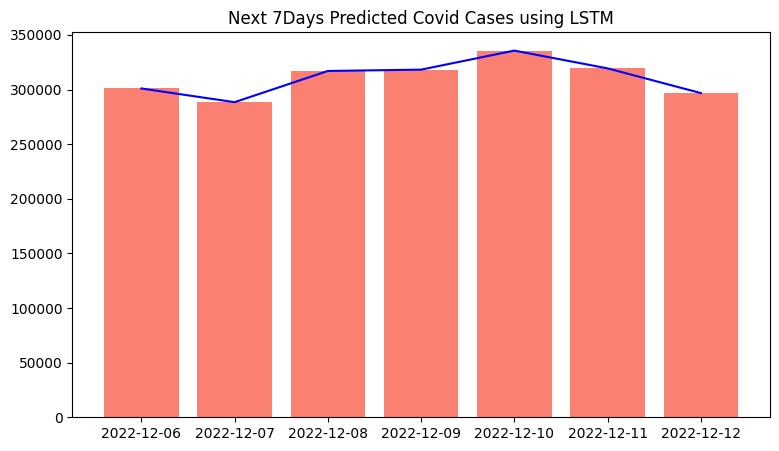

{'2022-12-06': 300941,
 '2022-12-07': 288403,
 '2022-12-08': 316967,
 '2022-12-09': 318189,
 '2022-12-10': 335601,
 '2022-12-11': 319332,
 '2022-12-12': 296732}

In [343]:
dict_dates_cases
print("Predicted cases for the next 7 days:\n")
print(dict_dates_cases)

names = list(dict_dates_cases.keys())
values = list(dict_dates_cases.values())

plt.figure(figsize=(9,5))
plt.bar(range(len(dict_dates_cases)), values, tick_label=names, color='salmon')
plt.plot(names,values, color='blue')
plt.title("Next 7Days Predicted Covid Cases using LSTM")
plt.show()
dict_dates_cases

